In [2]:
# Install necessary libraries
%pip install mediapipe opencv-python


  Using cached opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl (38.1 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: C:\Users\Aniyar\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [15]:
# import necessary libraries
import cv2
import mediapipe as mp
from IPython.display import display, Image, clear_output

In [18]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

In [19]:
# Load a video from local filesystem
video_file_name = "video_2023-09-05_21-18-36.mp4"

In [12]:
def identify_emotion(pose_landmarks):
    # Get the landmarks for the wrists, shoulders, elbows, and face
    left_wrist = pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST.value]
    right_wrist = pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST.value]
    left_elbow = pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW.value]
    right_elbow = pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW.value]
    left_shoulder = pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    right_shoulder = pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    nose = pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE.value]

    # Check if both wrists are above their respective shoulders
    wrists_above_shoulders = left_wrist.y < left_shoulder.y and right_wrist.y < right_shoulder.y

    # Check if both elbows are above their respective shoulders
    elbows_above_shoulders = left_elbow.y < left_shoulder.y and right_elbow.y < right_shoulder.y

    # Check the distance between wrists and nose to determine proximity to face
    left_distance_to_face = ((left_wrist.x - nose.x)**2 + (left_wrist.y - nose.y)**2)**0.5
    right_distance_to_face = ((right_wrist.x - nose.x)**2 + (right_wrist.y - nose.y)**2)**0.5

    # Define a threshold for determining if hands are close to the face
    threshold = 0.1

    # Check for criss-crossed arms
    criss_crossed =  left_wrist.x < right_wrist.x

    if wrists_above_shoulders and elbows_above_shoulders:
        return "happy"
    elif criss_crossed:
        return "fear"
    elif left_distance_to_face < threshold or right_distance_to_face < threshold:
        return "sad"
    return "neutral"


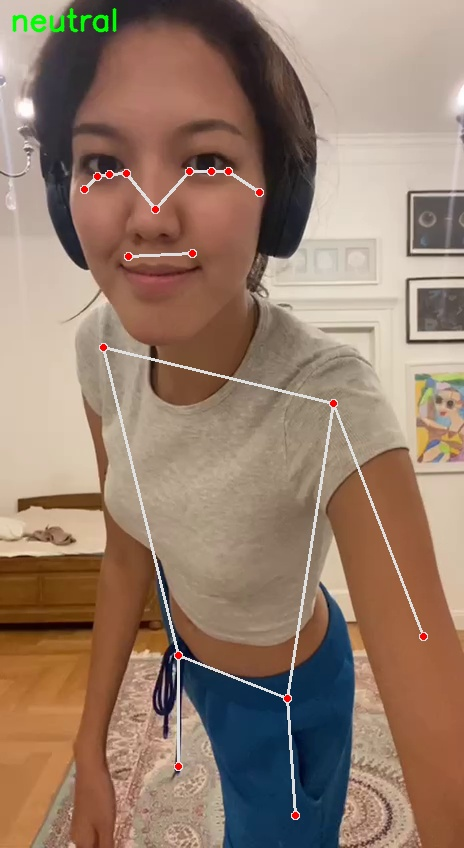

In [23]:
# Process video and detect poses
frame_emotions = []
cap = cv2.VideoCapture(video_file_name)
try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the BGR image to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame and get the pose landmarks
        results = pose.process(rgb_frame)

        # Draw the pose landmarks on the frame
        annotated_frame = frame.copy()
        if results.pose_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                annotated_frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Identify emotion and write the result on the frame
            emotion = identify_emotion(results.pose_landmarks)
            frame_emotions.append(emotion)
            cv2.putText(annotated_frame, emotion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
        # Convert the frame to JPEG and display it within the Jupyter Notebook
        _, jpeg_frame = cv2.imencode('.jpg', annotated_frame)
        display(Image(data=jpeg_frame.tobytes()))
        clear_output(wait=True)
except KeyboardInterrupt:
    # Allow the video display loop to be interrupted
    print("Interrupted!")
finally:
    cap.release()

In [24]:
def emotion_statistics(frame_emotions, frame_rate):
    # Initialize counters and variables
    emotion_durations = {}
    emotion_counts = {}
    current_emotion = frame_emotions[0]
    current_count = 0

    for emotion in frame_emotions:
        if emotion == current_emotion:
            current_count += 1
        else:
            # Update the total duration for the current emotion
            emotion_durations[current_emotion] = emotion_durations.get(current_emotion, 0) + (current_count / frame_rate)
            
            # Update the number of moments for the current emotion
            emotion_counts[current_emotion] = emotion_counts.get(current_emotion, 0) + 1
            
            # Reset the current emotion and count
            current_emotion = emotion
            current_count = 1

    # Handle the last emotion segment
    emotion_durations[current_emotion] = emotion_durations.get(current_emotion, 0) + (current_count / frame_rate)
    emotion_counts[current_emotion] = emotion_counts.get(current_emotion, 0) + 1

    # Print the results
    for emotion, duration in emotion_durations.items():
        print(f"Time the user was in {emotion} state: {duration:.2f} sec")
        print(f"Total number of {emotion} moments: {emotion_counts[emotion]}")
        print()

# Get emotion statistics
frame_rate = 30  
emotion_statistics(frame_emotions, frame_rate)


Time the user was in neutral state: 11.23 sec
Total number of neutral moments: 8

Time the user was in happy state: 5.70 sec
Total number of happy moments: 2

Time the user was in sad state: 5.13 sec
Total number of sad moments: 4

Time the user was in fear state: 7.03 sec
Total number of fear moments: 3

